In [18]:
# https://habr.com/ru/articles/599445/
# https://dzen.ru/a/ZNlXTs9VWE4YCAnx
# Скачать книгу можно отсюда: https://coollib.cc/b/651746-fransua-sholle-glubokoe-obuchenie-na-python
# КЛАССИФИКАЦИЯ ОТЗЫВОВ К ФИЛЬМАМ: ПРИМЕР БИНАРНОЙ КЛАССИФИКАЦИИ (стр. 137)
# Используется набор данных IMDB: множество из 50 000 отзывов (отрицательных и положительных поровну) к кинолентам в интернет-базе фильмов (Internet Movie Database).
# Набор разбит на 25 000 обучающих и 25 000 контрольных отзывов.
# Переменные train_labels и test_labels — это списки нулей и единиц, где 0 соответствуют отрицательным отзывам, а 1 — положительным.
#from tensorflow.keras.datasets import imdb    # старый вариант импорта, сейчас keras идет из api
from keras.datasets import imdb
from keras.api.layers import *
from keras.api.optimizers import *

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)  # загрузка IMDB из библиотеки Keras
# будет сохранено только 10000 слов, наиболее часто встречающихся в обучающем наборе отзывов. Редкие слова будут отброшены,
# что позволит работать с вектором управляемого размера. Если не установить данный предел, то модели придется столкнуться с 88 585 уникальными словами
# — это слишком много. Многие из них встречаются только в одном образце и поэтому не несут полезной информации для классификации

%whos   # просмотр переменных в рабочем пространстве
# train_data и test_data — это списки отзывов, каждый отзыв — это список индексов слов (кодированное представление последовательности слов).
# train_labels и test_labels — это списки нулей и единиц, где нули соответствуют отрицательным отзывам, а единицы — положительным.

No variables match your requested type.


In [19]:
#train_data[0]          # пример вывода отзыва
print(train_labels[0])  # пример вывода тональности отзыва
max([max(sequence) for sequence in train_data])  # максимальный индекс слова в наборах (напомним, сохранено только 10 000 слов)

1


9999

In [20]:
# Для иллюстрации - пример декодирования одного из отзывов в последовательность слов на английском языке
word_index = imdb.get_word_index() # словарь, отображающий слова в целочисленные индекс (соответсвия слово-индекс)
# Создаем словарь (неупорядоченные коллекции произвольных объектов с доступом по ключу) с помощью функции dict
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])  # обратное представление словаря, (индекс-слово): (52369: 'sugercoma')

# Преобразование словаря в строку методом join - объединяет список строк с помощью определенного указателя.
# Смещены на 3, потому что индексы 0, 1 и 2 зарезервированы для слов padding (отступ), # start of sequence и unknown (неизвестно)
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]) # ' '. - использовать пробел как разделитель между словами
decoded_review    # вывод на экран

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [21]:
#          Подготовка данных
# Нельзя передать списки целых чисел непосредственно в ИНС, так как все они имеют разную длину, поэтому надо преобразовать их в тензоры.
# Применим прямое кодирование списков в векторы нулей и единиц - ставим 1 на позицию, соответствующую номеру слова в словаре word_index.
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):  # enumerate создает пары "счётчик-элемент" из итерируемого объекта
        for j in sequence:   # j будет принимать индекс слова и на это место будет ставиться 1. Если слово несколько раз повторяется, это не учитывается
            results[i, j] = 1.
    return results
resultsx_train = vectorize_sequences(train_data)
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print('форма train_data =',train_data.shape,'\nформа x_train = ',x_train.shape)
print('пример содержимого строки (одного примера) x_train на входе ИНС:',x_train[0])

форма train_data = (25000,) 
форма x_train =  (25000, 10000)
пример содержимого строки (одного примера) x_train на входе ИНС: [0. 1. 1. ... 0. 0. 0.]


In [22]:
# векторизация меток
y_train = np.asarray(train_labels).astype('float32') # asarray в отличии от array стремится избегать создания копии, а преобразует сам исходный массив
y_test = np.asarray(test_labels).astype('float32')

In [23]:
# Конструирование модели (нейронной сети)
from tensorflow import keras
from keras.api import layers

model = keras.Sequential([
  layers.Dense(16, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

In [24]:
# Компиляция модели
model.compile(optimizer='rmsprop',
  loss='binary_crossentropy',
  metrics=['accuracy'])

In [25]:
# Создание обучающего и валидационного наборов
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]
x_val = x_train[:10000]
y_val = y_train[:10000]
# Обучение модели
history = model.fit(partial_x_train,partial_y_train,
  epochs=10,
  batch_size=512,
  validation_data=(x_val, y_val))

history_dict = history.history  # словарь с данными обо всем происходящем в процессе обучения
history_dict.keys()

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6771 - loss: 0.6165 - val_accuracy: 0.8449 - val_loss: 0.4631
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8849 - loss: 0.3885 - val_accuracy: 0.8665 - val_loss: 0.3614
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9111 - loss: 0.2911 - val_accuracy: 0.8877 - val_loss: 0.3024
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9353 - loss: 0.2258 - val_accuracy: 0.8735 - val_loss: 0.3129
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9415 - loss: 0.1912 - val_accuracy: 0.8858 - val_loss: 0.2819
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9508 - loss: 0.1646 - val_accuracy: 0.8878 - val_loss: 0.2777
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9638 - loss: 0.1310 - val_accuracy: 0.8813 - val_loss: 0.2923
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9675 - loss: 0.1182 - val_accuracy: 0.8848 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

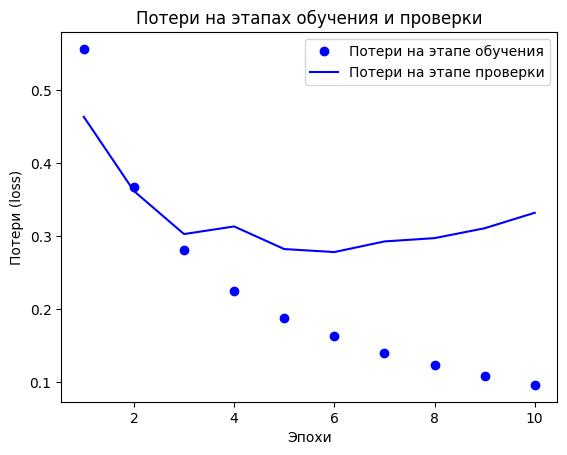

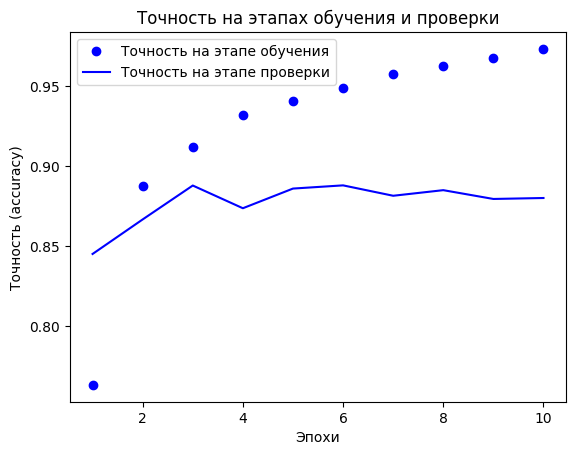

In [26]:
# Формирование графиков ПОТЕРЬ (loss) на этапах обучения и проверки
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss_values, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери (loss)")
plt.legend()
plt.show()

# Формирование графиков ТОЧНОСТИ (accuracy) на этапах обучения и проверки
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_acc, "b", label="Точность на этапе проверки")
plt.title("Точность на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Точность (accuracy)")
plt.legend()
plt.show()

In [27]:
# Из графиков видно - произошло переобучение: после четвертой эпохи произошла чрезмерная оптимизация на обучающих данных
# и в результате ИНС не обобщакт данные за пределами обучающего набора.
# Поэтому обучим новую модель с нуля в течение четырех эпох и затем оценим получившийся результат на контрольных данных.
model = keras.Sequential([
  layers.Dense(16, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(1, activation="sigmoid")
  ])
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)  # возвращает потери и точность модели в тестовом режиме
results # в резултате видно, что простейшее решение позволило достичь точности 88 %.

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7208 - loss: 0.5683
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9014 - loss: 0.2915
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9253 - loss: 0.2218
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9332 - loss: 0.1844
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8821 - loss: 0.2906


[0.2908475995063782, 0.8831999897956848]

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Истинные метки:       [0. 1. 1. 0. 1. 1. 1. 0. 0. 1.] 
Предсказанные метки:  [0. 1. 1. 1. 1. 1. 1. 0. 1. 1.] 



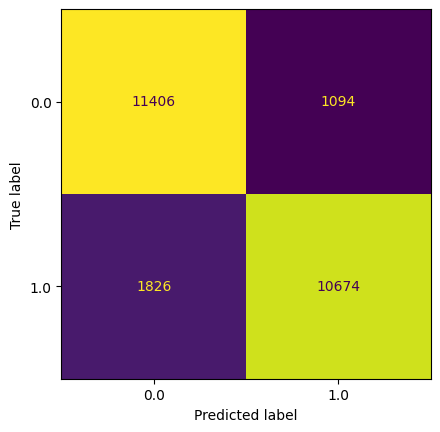

In [28]:
# Использование обученной ИНС для предсказаний на тестовом наборе данных

ans=model.predict(x_test) # классифиуируем отзывы
ans = np.reshape(ans, (len(y_test),)) # изменяем форму, чтобы она совпадала с y_test для наглядности отображения
q=np.round(ans) # округление до ближ. целого, т.е. порог принятие решения 0.5, например, 0.49 будет 0, а 0.51 станет 1
print('Истинные метки:      ',y_test[:10],'\nПредсказанные метки: ',q[:10],'\n')

# ОЦЕНКА ТОЧНОСТИ классификации - построние матрицы неточностей (confusion matrix)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,q,colorbar=False)

In [29]:
# ___  Применение ИНС на НОВОМ ОТЗЫВЕ, который вводится как переменная review1  ___

review1 = ["I really liked the film. Good acting. The plot is dynamic."] # НОВЫЙ ОТЗЫВ

# препроцессинг: преобразование символов в нижний регистр, удаление знаков пунктуации, разделение по пробелам
from tensorflow.keras.layers import TextVectorization        # cлой предварительной обработки
text_vectorization = TextVectorization( output_mode="int",)
text_vectorization.adapt(review1)
ss=text_vectorization.get_vocabulary()  # содержимое словаря (vocabulary - словарный запас)

In [30]:
# сопоставление слов из нового отзыва с имеющимися в imdb и определение их индекса
Dim_x=x_train.shape[1]      # размерность одного вектора вх. данных ИНС, [1] - берем 2ю размерность (кол. столбцов)
res = np.zeros((1, Dim_x))  # шаблон для вх. вектора ИНС, получаемого из нового отзыва

# word_index - содержит "слово-индекс", т.е. (value, key), например: 'sugercoma': 52369
# формируем вх. вектор res для ИНС на основе нового отзыва,res имеет вид,как одна строка в x_train,
# т.е. единицы находяться на местах номеров слов из отзыва, а остальные элементы - нули
for s1 in ss:    # цикл по строке отзыва
  for (key, value) in word_index.items():   # цикл по всем словам из словаря imdb
    if value <10000:
        if s1==key:          # если слово из отзыва совпадает с одним из слов словаря imdb
            res[0,value]=1.  # то на позицию value ставим 1

In [ ]:
# Здесь вставьте проверку правильности расстановки 1 в res



В словаре индексу  1244  соответствует слово  bought


In [31]:
# _________  ПРИМЕНЕНИЕ ИНС для класификации НОВОГО ОТЗЫВА  __________
ans=model.predict(res) # классифицируем отзыв
print('Уверенность ИНС в том, что новый отзыв положительный:  ',ans[0,0])

#ans=model.predict(x_train[0:1]) # пример классифиции отзывf из первой строки обучающих данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Уверенность ИНС в том, что новый отзыв положительный:   0.45936275
